In [1]:
import numpy as np
import serial
import time
import h5py
from datetime import datetime
from datetime import date
import cv2
from matplotlib import pyplot as plt

In [2]:
def tactile_reading(path):
    f = h5py.File(path, 'r')
    fc = f['frame_count'][0]
    ts = np.array(f['ts'][:fc])
    pressure = np.array(f['pressure'][:fc]).astype(np.float32)
    packetIDs = np.array(f['packetNumber'][:fc])
    return pressure, fc, ts, packetIDs

def split_into_segments(pressure, frame_count, time_stamp, packet_loss, N):
    # Calculate the total duration
    total_duration = time_stamp[-1] - time_stamp[0]
    
    # Calculate the approximate duration for each segment
    segment_duration = total_duration / N
    
    # Initialize lists to hold the segments
    pressure_segments = []
    frame_count_segments = []
    time_stamp_segments = []
    packet_loss_segments = []

    # Initialize the start index for the first segment
    start_index = 0

    for i in range(N):
        # Determine the end time for the current segment
        end_time = time_stamp[0] + (i + 1) * segment_duration
        
        # Find the index where the time_stamp exceeds the end_time
        end_index = np.searchsorted(time_stamp, end_time, side='right')
        
        # Slice the arrays to form the current segment
        pressure_segments.append(pressure[start_index:end_index])
        frame_count_segments.append(frame_count[start_index:end_index])
        time_stamp_segments.append(time_stamp[start_index:end_index])
        packet_loss_segments.append(packet_loss[start_index:end_index])
        
        # Update the start index for the next segment
        start_index = end_index

    return pressure_segments, frame_count_segments, time_stamp_segments, packet_loss_segments

#Return throughput in frames per second and Mbps
def getThroughput(ts, fc):
    return (fc[-1]-fc[0])/(ts[-1]-ts[0]), ((fc[-1]-fc[0])*66*32)/((ts[-1]-ts[0])*125000)

def getPacketLoss(packetLoss, fc):
    flattened = np.array([item for sublist in packetLoss for item in sublist])
    flattened = flattened[flattened!=0]
    expectedPackets = np.max(flattened)-np.min(flattened)
    packetsReceived = np.min((expectedPackets, len(flattened)))
    packetsLost = expectedPackets-packetsReceived 
    return packetsLost/(expectedPackets)

In [5]:
bleSenders = [['ble_test.hdf5']]
wifiSenders = []
espNowsenders = [['esp_baud.hdf5']]
#Key: (mean, std)
throughputDict = {
}
packetLossDict = {
}

AllSenders = [wifiSenders,bleSenders,espNowsenders]
keys = ['WiFi','BLE','Esp']
for i in range(3):
    totalSendExps = len(AllSenders[i])
    finalThroughputMeans = np.zeros(totalSendExps)
    finalThroughputStds = np.zeros(totalSendExps)
    finalPacketMeans = np.zeros(totalSendExps)
    finalPacketStds = np.zeros(totalSendExps)
    for j in range(totalSendExps):
        experiment = AllSenders[i][j]
        numSenders = len(experiment)
        numTrials = 5
        totalthroughput = np.zeros((1,numTrials))
        totalpacketloss = np.zeros((1,numTrials))
        for k in range(numSenders):
            file=experiment[k]
            pressure, fc, ts, packetLoss = tactile_reading(file)
            pressureSplit, fcSplit, tsSplit, packetLossSplit = split_into_segments(pressure,range(fc),ts,packetLoss,numTrials)
            packetLosses = np.array([getPacketLoss(packetLossSplit[i],fcSplit[i]) for i in range(numTrials)])
            framesPerSec = np.array([getThroughput(tsSplit[i],fcSplit[i])[0] for i in range(numTrials)])
            totalthroughput+=framesPerSec
            totalpacketloss+=packetLosses
        throughputPerSender = totalthroughput/numSenders
        packetLossPerSender = totalpacketloss/numSenders
        finalThroughputMeans[j]=np.mean(throughputPerSender)
        finalThroughputStds[j] = np.std(throughputPerSender)
        finalPacketMeans[j] = np.mean(packetLossPerSender)
        finalPacketStds[j] = np.std(packetLossPerSender)
    throughputDict[keys[i]] = (finalThroughputMeans, finalThroughputStds)
    packetLossDict[keys[i]] = (finalPacketMeans, finalPacketStds)

In [6]:
print(packetLossDict)
print(throughputDict)
a=packetLossSplit[1]
flattened = [item for sublist in a for item in sublist]
print(min(flattened),max(flattened),max(flattened)-min(flattened))
print(len(flattened))

{'WiFi': (array([], dtype=float64), array([], dtype=float64)), 'BLE': (array([0.82239119]), array([0.00327816])), 'Esp': (array([0.00235089]), array([0.00470178]))}
{'WiFi': (array([], dtype=float64), array([], dtype=float64)), 'BLE': (array([10.34844936]), array([0.1958785])), 'Esp': (array([27.19467202]), array([0.37138756]))}
0 32412 32412
4878


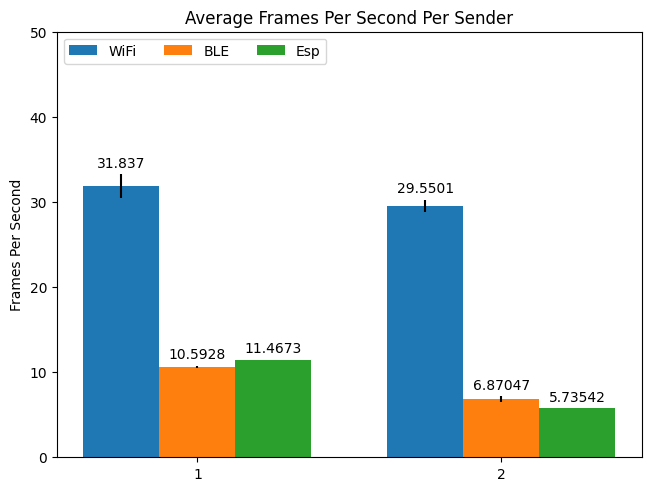

In [5]:
NumSenders = ("1", "2")
#Avg and Std
x = np.arange(len(NumSenders))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for protcol, measurement in throughputDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=protcol, yerr=measurement[1])
    ax.bar_label(rects, padding=3)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frames Per Second')
ax.set_title('Average Frames Per Second Per Sender')
ax.set_xticks(x + width, NumSenders)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 50)
ax.set_xlabel("Number of Senders")
plt.show()

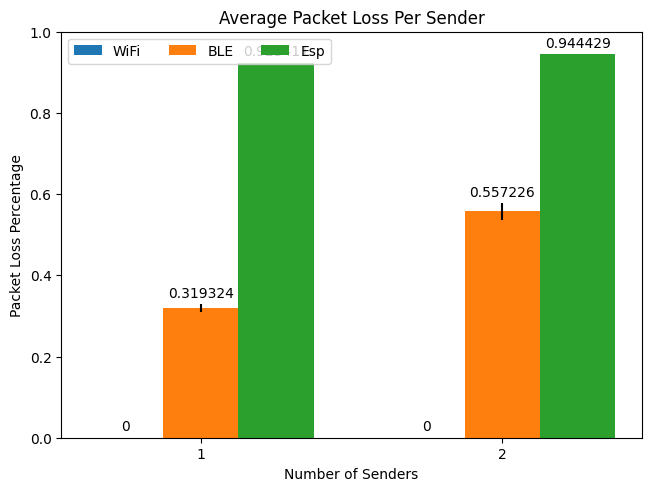

In [9]:
NumSenders = ("1", "2")
#Avg and Std
x = np.arange(len(NumSenders))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for protcol, measurement in packetLossDict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=protcol, yerr=measurement[1])
    ax.bar_label(rects, padding=3)
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Percentage')
ax.set_xlabel('Number of Senders')
ax.set_title('Average Packet Loss Per Sender')
ax.set_xticks(x + width, NumSenders)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)
plt.show()